<a href="https://colab.research.google.com/github/sayanbanerjee32/coreference-resolution/blob/main/data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Papers and blogs

End2End Coref Resolution By Attention RNN - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
coreference-resolution - https://www.kaggle.com/abhishekbhole/coreference-resolution  
SpanBERT - https://arxiv.org/pdf/1907.10529.pdf   
BERT for Coreference Resolution - https://arxiv.org/pdf/1908.09091.pdf  
GITHub for BERT and SpanBERT - https://github.com/mandarjoshi90/coref  
Fast AI solution - https://www.kaggle.com/mamamot/fastai-awd-lstm-solution-0-71-lb/notebook

In [1]:
%%capture
!pip install fastai -Uq

In [2]:
# mount gdrive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# file locations
train_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-development.tsv'
val_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-validate.tsv'
test_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-test.tsv'
model_save_path = '/content/drive/MyDrive/coref_resolution/models/'

In [4]:
import pandas as pd
from fastai.text.all import *
from pathlib import Path
from tqdm.notebook import tqdm

In [5]:
train_df = pd.read_csv(train_file_path,sep="\t")
test_df = pd.read_csv(test_file_path,sep="\t")
val_df = pd.read_csv(val_file_path,sep="\t")

In [6]:
train_df["Text"][0], train_df["Text"][1]

("Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.')

In [7]:
print(len(train_df), len(val_df), len(test_df))

2000 454 2000


## Fine tune language model

In [8]:
# lets keep val for final testing
df_pretrain = pd.concat([train_df, test_df])
df_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4000 non-null   object
 1   Text            4000 non-null   object
 2   Pronoun         4000 non-null   object
 3   Pronoun-offset  4000 non-null   int64 
 4   A               4000 non-null   object
 5   A-offset        4000 non-null   int64 
 6   A-coref         4000 non-null   bool  
 7   B               4000 non-null   object
 8   B-offset        4000 non-null   int64 
 9   B-coref         4000 non-null   bool  
 10  URL             4000 non-null   object
dtypes: bool(2), int64(3), object(6)
memory usage: 320.3+ KB


In [9]:
# fine tune language model
data_lm = DataBlock(
            blocks=TextBlock.from_df('Text', is_lm=True),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_pretrain) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj he was also first cousin of xxunk - un - xxunk , the xxmaj eldest xxmaj daughter of xxmaj his xxmaj uncle xxmaj aurangzeb . xxmaj his paternal aunts xxmaj xxunk xxmaj begum and xxmaj xxunk xxmaj begum and xxmaj xxunk xxmaj begum and xxmaj paternal xxmaj uncles xxmaj shah xxmaj xxunk , xxmaj aurangzeb , xxmaj he was called his grandfather of xxmaj xxunk i ` ` xxunk '","xxmaj he was also first cousin of xxunk - un - xxunk , the xxmaj eldest xxmaj daughter of xxmaj his xxmaj uncle xxmaj aurangzeb . xxmaj his paternal aunts xxmaj xxunk xxmaj begum and xxmaj xxunk xxmaj begum and xxmaj xxunk xxmaj begum and xxmaj paternal xxmaj uncles xxmaj shah xxmaj xxunk , xxmaj aurangzeb , xxmaj he was called his grandfather of xxmaj xxunk i ` ` xxunk ' '"
1,"to the house to xxunk before addressing the crowd outside , promising that xxmaj c*sar will be treated as a hero and his family will be taken care of . xxbos xxmaj based on the historical xxunk of the xxmaj xxunk study and on biographical examples such as xxmaj richard xxmaj xxunk , who had an xxup iq of 125 and went on to win the xxmaj xxunk xxmaj prize in physics","the house to xxunk before addressing the crowd outside , promising that xxmaj c*sar will be treated as a hero and his family will be taken care of . xxbos xxmaj based on the historical xxunk of the xxmaj xxunk study and on biographical examples such as xxmaj richard xxmaj xxunk , who had an xxup iq of 125 and went on to win the xxmaj xxunk xxmaj prize in physics and"


In [10]:
# create language model learner
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=True, 
    metrics=[accuracy, Perplexity()])#.to_fp16()

SuggestedLRs(valley=0.00363078061491251)

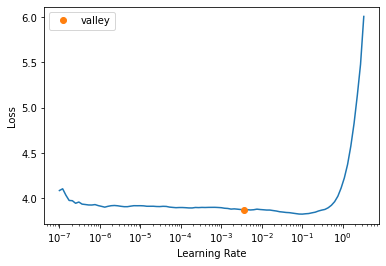

In [11]:
# find optimum learning rate for language model
learn_lm.lr_find()

In [12]:
# one cycle training
learn_lm.fit_one_cycle(1, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.721300,3.486765,0.371295,32.680069,00:17


In [13]:
# unfreeze all the layers and one cycle training
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.422962,3.314342,0.383444,27.504305,00:25
1,3.248590,3.277023,0.389537,26.496782,00:20
2,2.904625,3.329378,0.384006,27.920959,00:20
3,2.489187,3.404193,0.383429,30.090008,00:21
4,2.167397,3.478909,0.380423,32.424335,00:20


In [14]:
# save language model
learn_lm.save(Path(model_save_path) /'lm_fine_tuned')
learn_lm.save_encoder(Path(model_save_path) /'lm_fine_tuned_encoder')

In [15]:
# load pre-trained language model
# learn_lm_pretrained = load_learner(Path(model_save_path)/'lm_fine_tuned.pth', cpu = False)
# learn_lm.load(Path(model_save_path) /'lm_fine_tuned')

In [16]:
vocab = learn_lm.dls
# vocab.numericalize(tokenizer(train_df["Text"][0]))

## Pre-process data

In [17]:
import torch
from torch.utils.data import Dataset, TensorDataset

In [18]:
spacy_tok = SpacyTokenizer("en")
tokenizer = Tokenizer(spacy_tok)

In [19]:
# train_df["Text"][0], tokenizer(train_df["Text"][0])

In [20]:
import spacy
nlp = spacy.blank("en")

# note that 'xxunk' is not special in this sense
# special_tokens = ['xxbos','xxfld','xxpad', 'xxmaj','xxup','xxrep','xxwrep']

special_tokens = ['xxpad']

def get_token_num_by_offset(s, offset):
  s_pre = s[:offset]
  return len(tokenizer(s_pre))
  # return len([t for t in tokenizer(s_pre) if t not in special_tokens])


def adjust_token_num(processed, token_num):
  """
  As fastai tokenizer introduces additional tokens, we need to adjust for them.
  """
  counter = -1
  do_unrep = None
  for i, token in enumerate(processed):
    if token not in special_tokens:
      counter += 1
    # if do_unrep:
    #   do_unrep = False
    #   if processed[i+1] != ".":
    #     token_num -= (int(token) - 2) # one to account for the num itself
    #   else:  # spacy doesn't split full stops
    #     token_num += 1
    # if token == "xxrep":
    #   do_unrep = True
    if counter == token_num:
      return i
  else: # else for 'for'
    counter2 = -1
    for j, t in enumerate(processed):
      if t not in special_tokens:
        counter2 += 1
      # print(j, counter, t)
    raise Exception(f"{token_num} is out of bounds ({processed})")

In [21]:
import traceback
def dataframe_to_tensors(df, max_len=512):
  # offsets are: pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset
  offsets = list()
  labels = np.zeros((len(df),), dtype=np.int64)
  processed = list()
  for i, row in tqdm(df.iterrows()):
    try:
      text = row["Text"]
      a_offset = row["A-offset"]
      a_len = len(nlp(row["A"]))
      
      b_offset = row["B-offset"]
      b_len = len(nlp(row["B"]))

      pron_offset = row["Pronoun-offset"]
      is_a = row["A-coref"]
      is_b = row["B-coref"]
      a_tok_offset = get_token_num_by_offset(text, a_offset)
      b_tok_offset = get_token_num_by_offset(text, b_offset)
      a_right_offset = a_tok_offset + a_len - 1
      b_right_offset = b_tok_offset + b_len - 1
      pron_tok_offset = get_token_num_by_offset(text, pron_offset)
      tokenized = tokenizer(text)[:max_len]
      tokenized = ["xxpad"] * (max_len - len(tokenized))  + tokenized # add padding
      a_tok_offset = adjust_token_num(tokenized, a_tok_offset)
      a_tok_right_offset = adjust_token_num(tokenized, a_right_offset)
      b_tok_offset = adjust_token_num(tokenized, b_tok_offset)
      b_tok_right_offset = adjust_token_num(tokenized, b_right_offset)
      pron_tok_offset = adjust_token_num(tokenized, pron_tok_offset)
      numericalized = vocab.numericalize(tokenized)
      processed.append(torch.tensor(numericalized, dtype=torch.long))
      offsets.append([pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset])
      if is_a:
        labels[i] = 0
      elif is_b:
        labels[i] = 1
      else:
        labels[i] = 2
    except Exception as e:
      print(i)
      traceback.print_exc()
      raise
  processed = torch.stack(processed)
  offsets = torch.tensor(offsets, dtype=torch.long)
  labels = torch.from_numpy(labels)
  return processed, offsets, labels

In [22]:
train_ds = TensorDataset(*dataframe_to_tensors(train_df))
valid_ds = TensorDataset(*dataframe_to_tensors(val_df))
test_ds = TensorDataset(*dataframe_to_tensors(test_df))

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [23]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

### Classifier

In [24]:
learn_lm.freeze()

In [36]:
encoder_hidden_sz = 400

device = torch.device("cuda")

class CorefResolver(nn.Module):
  def __init__(self, encoder, dropout_p=0.3):
    super(CorefResolver, self).__init__()
    self.encoder = encoder
    self.dropout = nn.Dropout(dropout_p)
    self.hidden2hidden = nn.Linear(encoder_hidden_sz * 2 + 1, 25)
    self.hidden2logits = nn.Linear(50, 3)
    self.relu = nn.ReLU()
    self.activation = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def forward(self, seqs, offsets, labels=None):
    encoded = self.dropout(self.encoder(seqs)) #[0][2])
    a_q = list()
    b_q = list()
    for enc, offs in zip(encoded, offsets):
      # extract the hidden states that correspond to A, B and the pronoun, and make pairs of those 
      a_repr = enc[offs[2]]
      b_repr = enc[offs[4]]
      a_q.append(torch.cat([enc[offs[0]], a_repr, torch.dot(enc[offs[0]], a_repr).unsqueeze(0)]))
      b_q.append(torch.cat([enc[offs[0]], b_repr, torch.dot(enc[offs[0]], b_repr).unsqueeze(0)]))
    a_q = torch.stack(a_q)
    b_q = torch.stack(b_q)
    # apply the same "detector" layer to both batches of pairs
    is_a = self.relu(self.dropout(self.hidden2hidden(a_q)))
    is_b = self.relu(self.dropout(self.hidden2hidden(b_q)))
    # concatenate outputs of the "detector" layer to get the final probability distribution
    is_a_b = torch.cat([is_a, is_b], dim=1)
    is_logits = self.hidden2logits(self.dropout(self.relu(is_a_b)))

    activation = self.activation(is_logits)
    if labels is not None:
      return activation, self.loss(activation, labels)
    else:
      return activation

In [37]:
enc = learn_lm.model[0]

In [38]:
resolver = CorefResolver(enc)

In [39]:
resolver.to(device)

CorefResolver(
  (encoder): AWD_LSTM(
    (encoder): Embedding(10592, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10592, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (hidden2hidden): Linear(in_features=801, out_features=25, bias=True)
  (hidden2logits): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (activation): LogSoftmax(dim=1)
  (loss): NLLLoss()
)

In [40]:
for param in resolver.encoder.parameters():
  param.requires_grad = False

In [41]:
lr = 0.001

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(resolver.parameters(), lr=lr)

In [42]:
from sklearn.metrics import classification_report

In [43]:
def train_epoch(model, optimizer, train_dl, report_every=10):
  model.train()
  step = 0
  total_loss = 0
  
  for texts, offsets, labels in train_dl:
    texts, offsets, labels = texts.to(device), offsets.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    _, loss = model(texts, offsets, labels)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    if step % report_every == 0:
      print(f"Step {step}, loss: {total_loss/report_every}")
      total_loss = 0
      
def evaluate(model, optimizer, valid_dl, probas=False):
  probas = list()
  model.eval()
  predictions = list()
  total_loss = 0
  all_labels = list()
  with torch.no_grad():
    for texts, offsets, labels in valid_dl:
      texts, offsets, labels = texts.cuda(), offsets.cuda(), labels.cuda()
      preds, loss = model(texts, offsets, labels)
      total_loss += loss.item()
      probas.append(preds.cpu().detach().numpy())
      predictions.extend([i.item() for i in preds.max(1)[1]])
    
    
  print(f"Validation loss: {total_loss/len(valid_dl)}")
  print()
  print(classification_report(valid_dl.dataset.tensors[2].numpy(), predictions))
  if probas:
    return total_loss, np.vstack(probas)
  return total_loss, predictions

In [44]:
total_epoch = 0
best_loss = 1e6

for i in range(10):
  print("Epoch", i + 1)
  total_epoch += 1
  train_epoch(resolver, optimizer, train_dl) 
  loss, labels = evaluate(resolver, optimizer, test_dl)
  if loss < best_loss:
    best_loss = loss
    print(f"Loss improved, saving {total_epoch}")
    torch.save(resolver.state_dict(), Path(model_save_path)/"model_best.pt")

> <ipython-input-25-4a281dd0401b>(22)forward()
     20     for enc, offs in zip(encoded, offsets):
     21       # extract the hidden states that correspond to A, B and the pronoun, and make pairs of those
---> 22       a_repr = enc[offs[2]]
     23       b_repr = enc[offs[4]]
     24       a_q.append(torch.cat([enc[offs[0]], a_repr, torch.dot(enc[offs[0]], a_repr).unsqueeze(0)]))

ipdb> quit
Epoch 1
Step 10, loss: 1.0182713449001313
Step 20, loss: 0.9355005085468292
Step 30, loss: 0.9616895318031311
Validation loss: 0.976995587348938

              precision    recall  f1-score   support

           0       0.63      0.34      0.44       187
           1       0.51      0.88      0.65       205
           2       0.00      0.00      0.00        62

    accuracy                           0.54       454
   macro avg       0.38      0.41      0.36       454
weighted avg       0.49      0.54      0.47       454

Loss improved, saving 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2
Step 10, loss: 0.8755507469177246
Step 20, loss: 0.8905709683895111
Step 30, loss: 0.9042854249477387
Validation loss: 0.9289064606030782

              precision    recall  f1-score   support

           0       0.60      0.54      0.57       187
           1       0.55      0.77      0.64       205
           2       0.00      0.00      0.00        62

    accuracy                           0.57       454
   macro avg       0.39      0.44      0.40       454
weighted avg       0.50      0.57      0.53       454

Loss improved, saving 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3
Step 10, loss: 0.8490334451198578
Step 20, loss: 0.8741215407848358
Step 30, loss: 0.8454448401927948
Validation loss: 0.8992349863052368

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       187
           1       0.60      0.72      0.66       205
           2       0.00      0.00      0.00        62

    accuracy                           0.59       454
   macro avg       0.39      0.46      0.42       454
weighted avg       0.51      0.59      0.55       454

Loss improved, saving 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
loss, res = evaluate(resolver, optimizer, valid_dl, True)
res_s = np.exp(res)  # don't forget that we have log-softmax outputs:
test_res = pd.DataFrame(res_s, index=val_df["ID"], columns=["A", "B", "NEITHER"])
test_res.head()

Validation loss: 0.8994085947672527

              precision    recall  f1-score   support

           0       0.58      0.65      0.61       187
           1       0.60      0.72      0.66       205
           2       0.00      0.00      0.00        62

    accuracy                           0.59       454
   macro avg       0.39      0.46      0.42       454
weighted avg       0.51      0.59      0.55       454



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,A,B,NEITHER
ID,,,
validation-1,0.316870,0.603443,0.079688
validation-2,0.489353,0.423739,0.086909
validation-3,0.257313,0.639748,0.102939
validation-4,0.566800,0.343182,0.090018
validation-5,0.559244,0.282337,0.158419


In [48]:
val_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,validation-1,"He admitted making four trips to China and playing golf there. He also admitted that ZTE officials, whom he says are his golf buddies, hosted and paid for the trips. Jose de Venecia III, son of House Speaker Jose de Venecia Jr, alleged that Abalos offered him US$10 million to withdraw his proposal on the NBN project.",him,256,Jose de Venecia Jr,208,False,Abalos,241,False,http://en.wikipedia.org/wiki/Commission_on_Elections_(Philippines)
1,validation-2,"Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",She,185,Ellen,110,False,Kathleen,150,True,http://en.wikipedia.org/wiki/Kathleen_Nott
2,validation-3,"When she returns to her hotel room, a Liberian man (Tony Todd) forces her to smuggle $20 million worth of conflict diamonds to New York, or else fellow fight attendant and friend Angela will die. She is caught before she can board the flight, and the team now have nine hours until the plane lands, and save Angela. After the confiscated diamonds are stolen by the brother of Kaleo (Jason Scott Lee), whom Danny put away for murdering his partner last year, Five-0 and Chief Fryer team up and enlist the help of August March (Ed Asner), who served a 30-year sentence for smuggling diamonds.",his,435,Jason Scott Lee,383,False,Danny,406,True,"http://en.wikipedia.org/wiki/Hawaii_Five-0_(2010_TV_series,_season_2)"
3,validation-4,"On 19 March 2007, during a campaign appearance for the New South Wales State Election, the then opposition leader Peter Debnam was confronted by Reucassel wearing nothing but Speedos and a baseball cap, making fun of Debnam's campaign appearances in the swimwear. When TV cameras remained focused on Reucassel rather than Mr Debnam, he said, ``Sorry, I'm not Peter Debnam, he's over there.",he,333,Reucassel,300,True,Debnam,325,False,http://en.wikipedia.org/wiki/Craig_Reucassel
4,validation-5,"By this time, Karen Blixen had separated from her husband, and after their divorce in 1925, Finch Hatton moved into her house and began leading safaris for wealthy sportsmen. Among his clients were Marshall Field Jr and Edward, Prince of Wales. According to the author Mary Lovell, in 1930 Finch Hatton began a love affair with Beryl Markham, who was working as a race-horse trainer in Nairobi and the surrounding area. Later, she would become known as a pioneer flyer herself (Markham attributed her interest in flying to her association with Tom Campbell Black).",she,427,Finch Hatton,290,False,Beryl Markham,328,True,http://en.wikipedia.org/wiki/Denys_Finch_Hatton
